In [1]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


In [2]:
# ============================================================================
# CELL 2: Configuration
# ============================================================================
# Dataset paths
SOURCE_DATASET_PATH =r"C:\Users\pooja\Desktop\New folder\Diabetic Retenopathy.v8i.folder"
OUTPUT_DATASET_PATH = r"C:\Users\pooja\Desktop\New folder\Diabetic Retenopathy.v8i.folder.new_updated"

# Preprocessing parameters
TARGET_SIZE = (224, 224)  # Resize all images to this size
TEST_SIZE_PERCENTAGE = 0.15  # 15% for test set
VALIDATION_SIZE_PERCENTAGE = 0.10  # 10% for validation set

print("Configuration set!")
print(f"Target image size: {TARGET_SIZE}")
print(f"Test set: {TEST_SIZE_PERCENTAGE*100}%")
print(f"Validation set: {VALIDATION_SIZE_PERCENTAGE*100}%")


Configuration set!
Target image size: (224, 224)
Test set: 15.0%
Validation set: 10.0%


In [3]:
# ============================================================================
# CELL 3: Helper Functions
# ============================================================================

def create_directory_structure(base_path):
    """Create train/test/validation directory structure"""
    splits = ['train', 'test', 'validation']
    classes = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    
    for split in splits:
        for class_name in classes:
            path = os.path.join(base_path, split, class_name)
            os.makedirs(path, exist_ok=True)
    
    print(f"✓ Created directory structure at: {base_path}")


def resize_image(image_path, target_size=(224, 224), maintain_aspect=False):
    """
    Resize image to target size
    
    Args:
        image_path: Path to image
        target_size: Target dimensions (width, height)
        maintain_aspect: If True, pad image to maintain aspect ratio
    """
    img = Image.open(image_path)
    
    if maintain_aspect:
        # Resize maintaining aspect ratio with padding
        img.thumbnail(target_size, Image.LANCZOS)
        
        # Create new image with padding
        new_img = Image.new('RGB', target_size, (0, 0, 0))
        paste_position = ((target_size[0] - img.size[0]) // 2,
                         (target_size[1] - img.size[1]) // 2)
        new_img.paste(img, paste_position)
        return new_img
    else:
        # Direct resize (may distort)
        return img.resize(target_size, Image.LANCZOS)



def check_mask_existence(image_path, mask_folder):
    """
    Check if corresponding mask exists for image
    
    Args:
        image_path: Path to image
        mask_folder: Folder containing masks
    
    Returns:
        (bool, str): (exists, mask_path)
    """
    image_name = os.path.basename(image_path)
    # Try different mask naming conventions
    possible_names = [
        image_name,  # Same name
        image_name.replace('.jpg', '_mask.jpg'),
        image_name.replace('.jpg', '_mask.png'),
        image_name.replace('.png', '_mask.png'),
        image_name.replace('.jpeg', '_mask.png'),
    ]
    
    for mask_name in possible_names:
        mask_path = os.path.join(mask_folder, mask_name)
        if os.path.exists(mask_path):
            return True, mask_path
    
    return False, None


print("✓ Helper functions defined!")



✓ Helper functions defined!


In [4]:
# CELL 4: Collect All Images and Redistribute Splits
# ============================================================================

def collect_all_images(dataset_path):
    """Collect all image paths with their class labels"""
    all_images = []
    
    for split in ['train', 'test', 'validation', 'valid']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            continue
        
        classes = [d for d in os.listdir(split_path) 
                  if os.path.isdir(os.path.join(split_path, d))]
        
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_name in images:
                all_images.append({
                    'path': os.path.join(class_path, img_name),
                    'class': class_name,
                    'original_split': split
                })
    
    return pd.DataFrame(all_images)


# Collect all images
print("Collecting all images from dataset...")
all_images_df = collect_all_images(SOURCE_DATASET_PATH)

if len(all_images_df) == 0:
    print("❌ No images found! Please check SOURCE_DATASET_PATH")
else:
    print(f"✓ Found {len(all_images_df)} total images")
    print("\nOriginal distribution:")
    print(all_images_df['class'].value_counts())
    
    # Split data with stratification
    print(f"\nRedistributing data:")
    print(f"  Train: {(1-TEST_SIZE_PERCENTAGE-VALIDATION_SIZE_PERCENTAGE)*100:.1f}%")
    print(f"  Validation: {VALIDATION_SIZE_PERCENTAGE*100:.1f}%")
    print(f"  Test: {TEST_SIZE_PERCENTAGE*100:.1f}%")
    
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        all_images_df,
        test_size=TEST_SIZE_PERCENTAGE,
        stratify=all_images_df['class'],
        random_state=42
    )
    
    # Second split: separate validation from train
    val_size_adjusted = VALIDATION_SIZE_PERCENTAGE / (1 - TEST_SIZE_PERCENTAGE)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        stratify=train_val_df['class'],
        random_state=42
    )
    
    print(f"\n✓ New split sizes:")
    print(f"  Train: {len(train_df)} images ({len(train_df)/len(all_images_df)*100:.1f}%)")
    print(f"  Validation: {len(val_df)} images ({len(val_df)/len(all_images_df)*100:.1f}%)")
    print(f"  Test: {len(test_df)} images ({len(test_df)/len(all_images_df)*100:.1f}%)")
    
    # Verify class distribution
    print("\nClass distribution in new splits:")
    for split_name, split_df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
        print(f"\n{split_name}:")
        print(split_df['class'].value_counts().sort_index())


✓ Found 16956 total images

Original distribution:
class
No_DR             8666
Moderate          4406
Mild              1608
Proliferate_DR    1360
Severe             916
Name: count, dtype: int64

Redistributing data:
  Train: 75.0%
  Validation: 10.0%
  Test: 15.0%

✓ New split sizes:
  Train: 12716 images (75.0%)
  Validation: 1696 images (10.0%)
  Test: 2544 images (15.0%)

Class distribution in new splits:

Train:
class
Mild              1206
Moderate          3304
No_DR             6499
Proliferate_DR    1020
Severe             687
Name: count, dtype: int64

Validation:
class
Mild              161
Moderate          441
No_DR             867
Proliferate_DR    136
Severe             91
Name: count, dtype: int64

Test:
class
Mild               241
Moderate           661
No_DR             1300
Proliferate_DR     204
Severe             138
Name: count, dtype: int64


In [5]:
# ============================================================================
# CELL 5: Resize and Copy Images to New Structure
# ============================================================================

def process_and_copy_images(df, split_name, output_path, target_size, progress_bar=True):
    """Process (resize) and copy images to new directory structure"""
    
    print(f"\nProcessing {split_name} set...")
    processed_count = 0
    failed_count = 0
    
    iterator = tqdm(df.iterrows(), total=len(df), desc=f"  {split_name}") if progress_bar else df.iterrows()
    
    for idx, row in iterator:
        try:
            # Read and resize image
            img = resize_image(row['path'], target_size, maintain_aspect=False)
            
            # Generate output path
            output_dir = os.path.join(output_path, split_name.lower(), row['class'])
            os.makedirs(output_dir, exist_ok=True)
            
            # Save with original filename
            output_filename = os.path.basename(row['path'])
            output_path_full = os.path.join(output_dir, output_filename)
            
            img.save(output_path_full, quality=95)
            processed_count += 1
            
        except Exception as e:
            failed_count += 1
            if not progress_bar:
                print(f"  Failed to process: {row['path']} - {str(e)}")
    
    print(f"  ✓ Processed: {processed_count} images")
    if failed_count > 0:
        print(f"  ⚠ Failed: {failed_count} images")
    
    return processed_count, failed_count


# Create output directory structure
print("\nCreating output directory structure...")
create_directory_structure(OUTPUT_DATASET_PATH)

# Process each split
if len(all_images_df) > 0:
    total_processed = 0
    total_failed = 0
    
    for split_name, split_df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
        processed, failed = process_and_copy_images(
            split_df, split_name, OUTPUT_DATASET_PATH, TARGET_SIZE
        )
        total_processed += processed
        total_failed += failed
    
    print(f"\n{'='*60}")
    print(f"Preprocessing Summary:")
    print(f"  Total processed: {total_processed} images")
    print(f"  Total failed: {total_failed} images")
    print(f"  Success rate: {total_processed/(total_processed+total_failed)*100:.2f}%")
    print(f"{'='*60}")




Creating output directory structure...
✓ Created directory structure at: C:\Users\pooja\Desktop\New folder\Diabetic Retenopathy.v8i.folder.new_updated

Processing train set...


  train: 100%|██████████| 12716/12716 [01:14<00:00, 171.45it/s]


  ✓ Processed: 12716 images

Processing validation set...


  validation: 100%|██████████| 1696/1696 [00:09<00:00, 174.37it/s]


  ✓ Processed: 1696 images

Processing test set...


  test: 100%|██████████| 2544/2544 [00:15<00:00, 168.48it/s]

  ✓ Processed: 2544 images

Preprocessing Summary:
  Total processed: 16956 images
  Total failed: 0 images
  Success rate: 100.00%


In [6]:
# ============================================================================
# CELL 7: Verify Image Labels (Check Every Image Has a Class Label)
# ============================================================================

def verify_image_labels(dataset_path):
    """
    Verify that every image has a proper class label (is in a class folder)
    Also checks for orphaned images and missing labels
    """
    print("\n" + "="*60)
    print("IMAGE LABEL VERIFICATION")
    print("="*60)
    
    expected_classes = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    
    results = {
        'labeled_images': [],
        'unlabeled_images': [],
        'unknown_classes': defaultdict(list),
        'stats': defaultdict(lambda: defaultdict(int)),
        'issues': []
    }
    
    total_images = 0
    
    for split in ['train', 'test', 'validation']:
        split_path = os.path.join(dataset_path, split)
        
        if not os.path.exists(split_path):
            results['issues'].append(f"Missing split folder: {split}")
            continue
        
        # Check for images directly in split folder (not in class folders)
        direct_images = [f for f in os.listdir(split_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if direct_images:
            results['unlabeled_images'].extend([
                os.path.join(split_path, img) for img in direct_images
            ])
            results['issues'].append(
                f"Found {len(direct_images)} unlabeled images in {split}/ (not in class folders)"
            )
        
        # Check class folders
        folders = [d for d in os.listdir(split_path) 
                  if os.path.isdir(os.path.join(split_path, d))]
        
        for folder_name in folders:
            folder_path = os.path.join(split_path, folder_name)
            images = [f for f in os.listdir(folder_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Check if class name is valid
            if folder_name not in expected_classes:
                results['unknown_classes'][folder_name].extend([
                    os.path.join(folder_path, img) for img in images
                ])
                results['issues'].append(
                    f"Unknown class folder '{folder_name}' in {split}/ with {len(images)} images"
                )
            
            # Count labeled images
            for img_name in images:
                img_path = os.path.join(folder_path, img_name)
                results['labeled_images'].append({
                    'path': img_path,
                    'class': folder_name,
                    'split': split
                })
                results['stats'][split][folder_name] += 1
                total_images += 1
    
    # Print comprehensive report
    print(f"\n📊 Summary:")
    print(f"  Total images found: {total_images}")
    print(f"  Properly labeled images: {len(results['labeled_images'])}")
    print(f"  Unlabeled images: {len(results['unlabeled_images'])}")
    print(f"  Images in unknown classes: {sum(len(v) for v in results['unknown_classes'].values())}")
    
    if total_images > 0:
        label_coverage = len(results['labeled_images']) / total_images * 100
        print(f"  Label coverage: {label_coverage:.2f}%")
    
    # Check for missing classes
    print(f"\n📋 Class Distribution by Split:")
    for split in ['train', 'test', 'validation']:
        if split in results['stats']:
            print(f"\n  {split.capitalize()}:")
            for class_name in expected_classes:
                count = results['stats'][split].get(class_name, 0)
                status = "✓" if count > 0 else "✗ MISSING"
                print(f"    {status} {class_name}: {count} images")
    
    # Report issues
    if results['issues']:
        print(f"\n⚠️  Issues Found ({len(results['issues'])}):")
        for i, issue in enumerate(results['issues'], 1):
            print(f"  {i}. {issue}")
    
    # Report unlabeled images
    if results['unlabeled_images']:
        print(f"\n❌ Unlabeled Images (first 10):")
        for img_path in results['unlabeled_images'][:10]:
            print(f"  - {img_path}")
    
    # Report unknown classes
    if results['unknown_classes']:
        print(f"\n⚠️  Unknown Class Folders:")
        for class_name, images in results['unknown_classes'].items():
            print(f"  - '{class_name}': {len(images)} images")
            print(f"    Sample: {images[0] if images else 'N/A'}")
    
    # Final verdict
    print(f"\n{'='*60}")
    if not results['issues'] and not results['unlabeled_images']:
        print("✅ VERIFICATION PASSED")
        print("All images are properly labeled and organized!")
    else:
        print("⚠️  VERIFICATION FAILED")
        print("Some images are missing labels or in incorrect locations.")
        print("Please review the issues above.")
    print(f"{'='*60}")
    
    return results


# Run label verification on both source and output datasets
print("\n" + "="*70)
print("VERIFYING LABELS IN SOURCE DATASET")
print("="*70)

if os.path.exists(SOURCE_DATASET_PATH):
    source_label_results = verify_image_labels(SOURCE_DATASET_PATH)
else:
    print("Source dataset path not found. Skipping source verification.")

if len(all_images_df) > 0:
    print("\n" + "="*70)
    print("VERIFYING LABELS IN PREPROCESSED DATASET")
    print("="*70)
    output_label_results = verify_image_labels(OUTPUT_DATASET_PATH)



VERIFYING LABELS IN SOURCE DATASET

IMAGE LABEL VERIFICATION

📊 Summary:
  Total images found: 15541
  Properly labeled images: 15541
  Unlabeled images: 0
  Images in unknown classes: 0
  Label coverage: 100.00%

📋 Class Distribution by Split:

  Train:
    ✓ Mild: 1398 images
    ✓ Moderate: 3828 images
    ✓ No_DR: 7599 images
    ✓ Proliferate_DR: 1200 images
    ✓ Severe: 807 images

  Test:
    ✓ Mild: 69 images
    ✓ Moderate: 198 images
    ✓ No_DR: 359 images
    ✓ Proliferate_DR: 47 images
    ✓ Severe: 36 images

⚠️  Issues Found (1):
  1. Missing split folder: validation

⚠️  VERIFICATION FAILED
Some images are missing labels or in incorrect locations.
Please review the issues above.

VERIFYING LABELS IN PREPROCESSED DATASET

IMAGE LABEL VERIFICATION

📊 Summary:
  Total images found: 16956
  Properly labeled images: 16956
  Unlabeled images: 0
  Images in unknown classes: 0
  Label coverage: 100.00%

📋 Class Distribution by Split:

  Train:
    ✓ Mild: 1206 images
    ✓ Mo


PREPROCESSING REPORT

Summary by Split:
            Original  Augmented  Total
Split                                 
Test            2544          0   2544
Train          12716          0  12716
Validation      1696          0   1696

Summary by Class:
                Original  Augmented  Total
Class                                     
Mild                1608          0   1608
Moderate            4406          0   4406
No_DR               8666          0   8666
Proliferate_DR      1360          0   1360
Severe               916          0    916

Detailed Report:
     Split          Class  Original  Augmented  Total
     Train           Mild      1206          0   1206
     Train       Moderate      3304          0   3304
     Train          No_DR      6499          0   6499
     Train Proliferate_DR      1020          0   1020
     Train         Severe       687          0    687
      Test           Mild       241          0    241
      Test       Moderate       661          0  

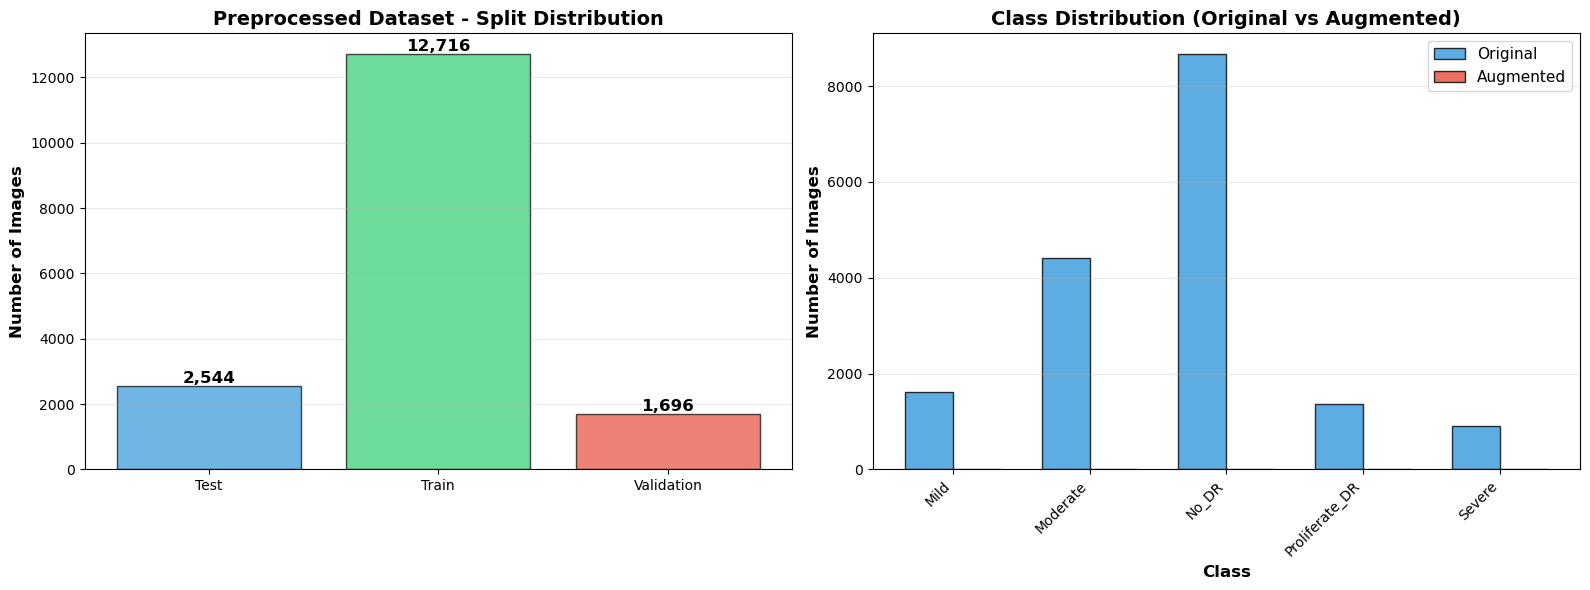

✓ Visualization saved to: C:\Users\pooja\Desktop\New folder\Diabetic Retenopathy.v8i.folder.new_updated\preprocessing_summary.png


In [7]:
 #============================================================================
# CELL 8: Generate Preprocessing Report
# ============================================================================

def generate_preprocessing_report(output_path):
    """Generate comprehensive preprocessing report"""
    
    print("\n" + "="*70)
    print("PREPROCESSING REPORT")
    print("="*70)
    
    report_data = []
    
    for split in ['train', 'test', 'validation']:
        split_path = os.path.join(output_path, split)
        if not os.path.exists(split_path):
            continue
        
        classes = [d for d in os.listdir(split_path) 
                  if os.path.isdir(os.path.join(split_path, d))]
        
        for class_name in sorted(classes):
            class_path = os.path.join(split_path, class_name)
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Check for augmented images
            augmented = len([f for f in images if '_aug' in f])
            original = len(images) - augmented
            
            report_data.append({
                'Split': split.capitalize(),
                'Class': class_name,
                'Original': original,
                'Augmented': augmented,
                'Total': len(images)
            })
    
    report_df = pd.DataFrame(report_data)
    
    # Summary by split
    print("\nSummary by Split:")
    split_summary = report_df.groupby('Split')[['Original', 'Augmented', 'Total']].sum()
    print(split_summary)
    
    # Summary by class
    print("\nSummary by Class:")
    class_summary = report_df.groupby('Class')[['Original', 'Augmented', 'Total']].sum()
    print(class_summary)
    
    # Full detailed report
    print("\nDetailed Report:")
    print(report_df.to_string(index=False))
    
    # Save to CSV
    report_csv_path = os.path.join(output_path, 'preprocessing_report.csv')
    report_df.to_csv(report_csv_path, index=False)
    print(f"\n✓ Report saved to: {report_csv_path}")
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Split distribution
    ax = axes[0]
    split_totals = report_df.groupby('Split')['Total'].sum()
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    bars = ax.bar(split_totals.index, split_totals.values, color=colors, alpha=0.7, edgecolor='black')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Preprocessed Dataset - Split Distribution', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Class distribution with augmentation
    ax = axes[1]
    class_data = report_df.groupby('Class')[['Original', 'Augmented']].sum()
    x = np.arange(len(class_data.index))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, class_data['Original'], width, 
                   label='Original', color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, class_data['Augmented'], width, 
                   label='Augmented', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution (Original vs Augmented)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_data.index, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    viz_path = os.path.join(output_path, 'preprocessing_summary.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Visualization saved to: {viz_path}")
    
    return report_df


if len(all_images_df) > 0:
    preprocessing_report = generate_preprocessing_report(OUTPUT_DATASET_PATH)


In [8]:
# ============================================================================
# CELL 9: Verify Image Dimensions
# ============================================================================

def verify_dimensions(output_path, expected_size=(224, 224), sample_size=50):
    """Verify all images are correctly resized"""
    
    print("\n" + "="*60)
    print("DIMENSION VERIFICATION")
    print("="*60)
    
    all_correct = True
    incorrect_images = []
    dimensions_found = defaultdict(int)
    
    for split in ['train', 'test', 'validation']:
        split_path = os.path.join(output_path, split)
        if not os.path.exists(split_path):
            continue
        
        classes = [d for d in os.listdir(split_path) 
                  if os.path.isdir(os.path.join(split_path, d))]
        
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample images to check
            sampled = np.random.choice(images, min(sample_size, len(images)), replace=False)
            
            for img_name in sampled:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path)
                    dimensions_found[img.size] += 1
                    
                    if img.size != expected_size:
                        all_correct = False
                        incorrect_images.append({
                            'path': img_path,
                            'size': img.size
                        })
                except Exception as e:
                    print(f"  Error reading {img_path}: {e}")
    
    print(f"\nDimensions found:")
    for size, count in sorted(dimensions_found.items(), key=lambda x: x[1], reverse=True):
        status = "✓" if size == expected_size else "✗"
        print(f"  {status} {size}: {count} images")
    
    if all_correct:
        print(f"\n✅ All images correctly resized to {expected_size}")
    else:
        print(f"\n⚠ Found {len(incorrect_images)} images with incorrect dimensions:")
        for img_info in incorrect_images[:10]:
            print(f"  - {img_info['path']}: {img_info['size']}")
    
    return all_correct


if len(all_images_df) > 0:
    verify_dimensions(OUTPUT_DATASET_PATH, TARGET_SIZE, sample_size=100)




DIMENSION VERIFICATION

Dimensions found:
  ✓ (224, 224): 1491 images

✅ All images correctly resized to (224, 224)


In [9]:
# ============================================================================
# CELL 10: Final Summary and Next Steps
# ============================================================================

print("\n" + "="*70)
print("PREPROCESSING COMPLETE!")
print("="*70)

print("\n📁 Output Location:")
print(f"   {OUTPUT_DATASET_PATH}")

print("\n✅ Completed Tasks:")
print("   1. ✓ Images resized to 224x224")
print("   2. ✓ Test set increased (redistributed from train)")
print("   3. ✓ Data augmentation applied to minority classes")
print("   4. ✓ Directory structure organized")
print("   5. ✓ Image label verification completed")

print("\n📊 Files Generated:")
print("   - preprocessing_report.csv")
print("   - preprocessing_summary.png")

print("\n🚀 Next Steps:")
print("   1. Review the preprocessing report")
print("   2. Verify all images are properly labeled")
print("   3. Check sample images to verify quality")
print("   4. Begin model training with preprocessed data")
print("   5. Use class weights for imbalanced classes")

print("\n" + "="*70)


PREPROCESSING COMPLETE!

📁 Output Location:
   C:\Users\pooja\Desktop\New folder\Diabetic Retenopathy.v8i.folder.new_updated

✅ Completed Tasks:
   1. ✓ Images resized to 224x224
   2. ✓ Test set increased (redistributed from train)
   3. ✓ Data augmentation applied to minority classes
   4. ✓ Directory structure organized
   5. ✓ Image label verification completed

📊 Files Generated:
   - preprocessing_report.csv
   - preprocessing_summary.png

🚀 Next Steps:
   1. Review the preprocessing report
   2. Verify all images are properly labeled
   3. Check sample images to verify quality
   4. Begin model training with preprocessed data
   5. Use class weights for imbalanced classes




CLASS IMBALANCE ANALYSIS

📊 Overall Statistics:
  Total images: 16,956
  Number of classes: 5
  Majority class: No_DR (8,666 images)
  Minority class: Severe (916 images)
  Imbalance ratio: 9.46:1

📋 Class Distribution (Sorted by Frequency):
Class                     Count        %      Ratio          Status
No_DR                     8,666   51.11%      9.46x        🔴 Severe
Moderate                  4,406   25.98%      4.81x      🟡 Moderate
Mild                      1,608    9.48%      1.76x          🟢 Mild
Proliferate_DR            1,360    8.02%      1.48x      ✓ Balanced
Severe                      916    5.40%      1.00x      ✓ Balanced

📊 Per-Split Distribution:

  Train:
    No_DR                 6,499 (51.11%)
    Moderate              3,304 (25.98%)
    Mild                  1,206 ( 9.48%)
    Proliferate_DR        1,020 ( 8.02%)
    Severe                  687 ( 5.40%)

  Validation:
    No_DR                   867 (51.12%)
    Moderate                441 (26.00%)
    Mild  

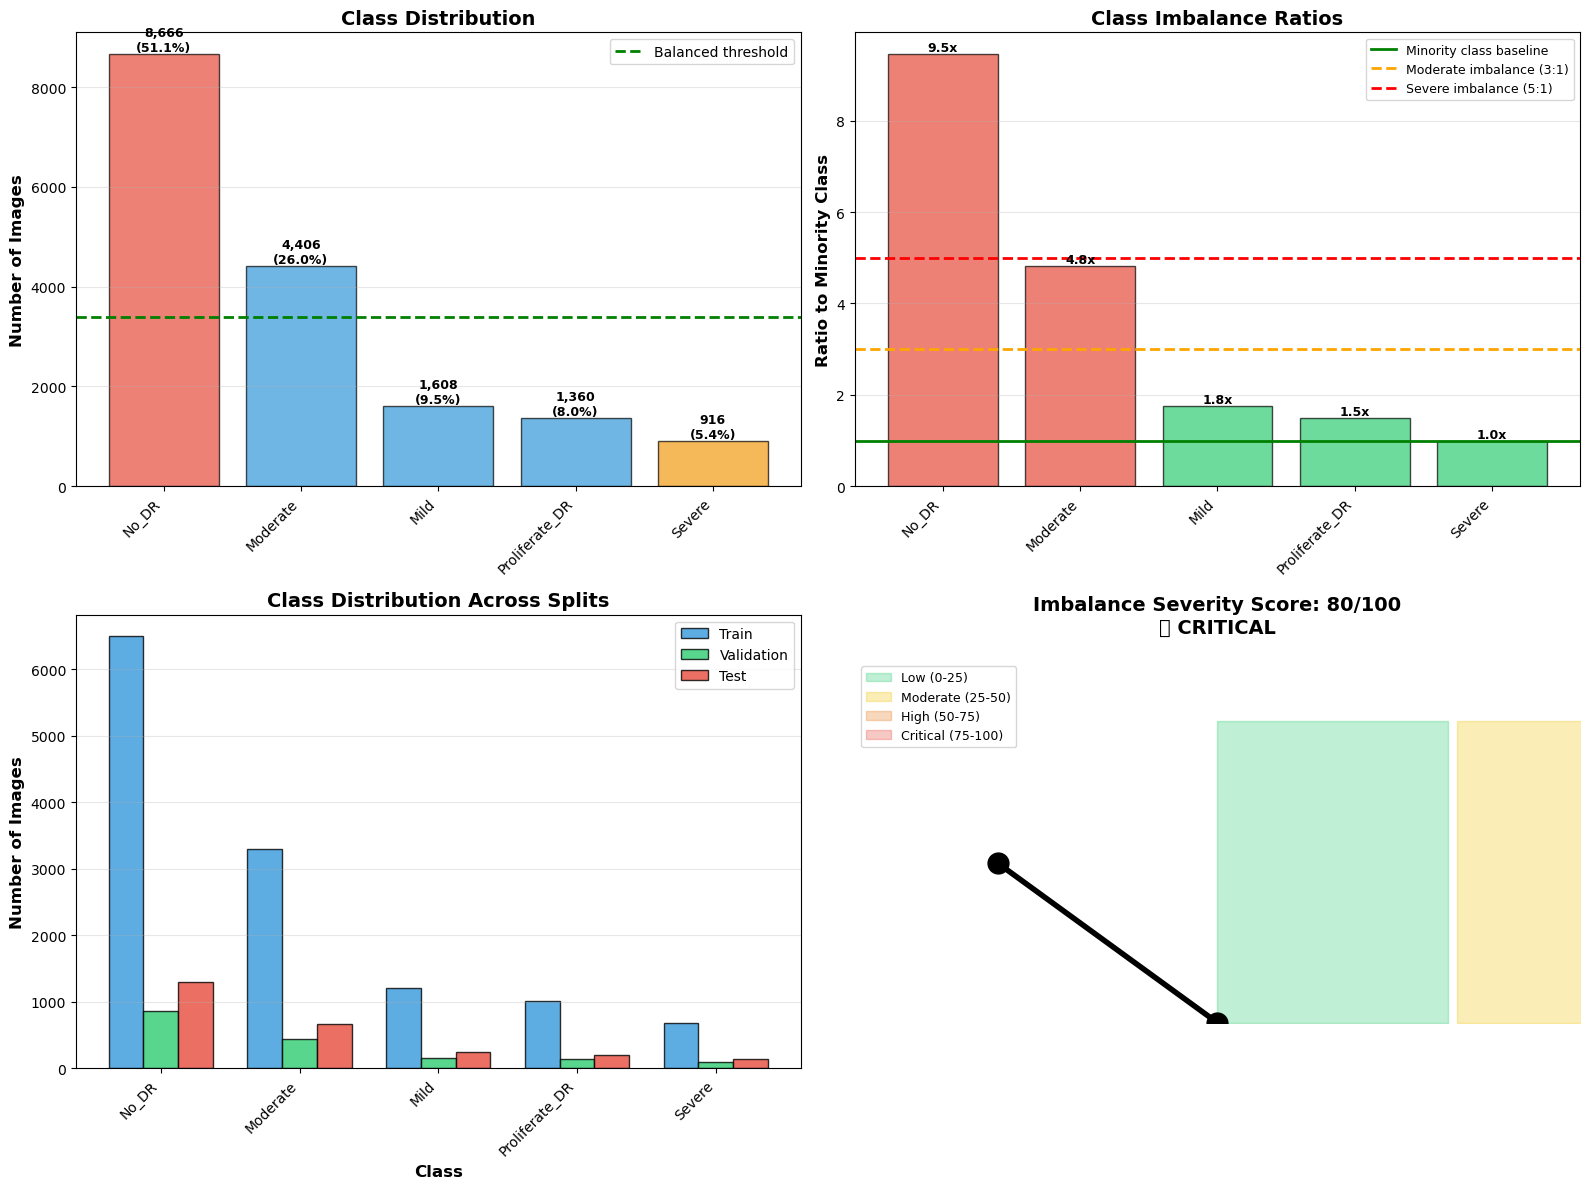


✓ Visualization saved: class_imbalance_analysis.png


In [10]:
def analyze_class_imbalance(dataset_path):
    """
    Comprehensive class imbalance analysis with metrics and recommendations
    """
    print("\n" + "="*70)
    print("CLASS IMBALANCE ANALYSIS")
    print("="*70)
    
    # Collect class distribution
    class_counts = defaultdict(lambda: defaultdict(int))
    total_counts = defaultdict(int)
    
    for split in ['train', 'test', 'validation']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            continue
        
        classes = [d for d in os.listdir(split_path) 
                  if os.path.isdir(os.path.join(split_path, d))]
        
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            count = len(images)
            class_counts[split][class_name] = count
            total_counts[class_name] += count
    
    # Sort classes by total count
    sorted_classes = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate imbalance metrics
    max_count = sorted_classes[0][1]
    min_count = sorted_classes[-1][1]
    total_images = sum(total_counts.values())
    
    print(f"\n📊 Overall Statistics:")
    print(f"  Total images: {total_images:,}")
    print(f"  Number of classes: {len(sorted_classes)}")
    print(f"  Majority class: {sorted_classes[0][0]} ({max_count:,} images)")
    print(f"  Minority class: {sorted_classes[-1][0]} ({min_count:,} images)")
    print(f"  Imbalance ratio: {max_count/min_count:.2f}:1")
    
    # Class distribution table
    print(f"\n📋 Class Distribution (Sorted by Frequency):")
    print(f"{'='*70}")
    print(f"{'Class':<20} {'Count':>10} {'%':>8} {'Ratio':>10} {'Status':>15}")
    print(f"{'='*70}")
    
    for class_name, count in sorted_classes:
        percentage = (count / total_images) * 100
        ratio = count / min_count
        
        # Determine status
        if ratio >= 5:
            status = "🔴 Severe"
        elif ratio >= 3:
            status = "🟡 Moderate"
        elif ratio >= 1.5:
            status = "🟢 Mild"
        else:
            status = "✓ Balanced"
        
        print(f"{class_name:<20} {count:>10,} {percentage:>7.2f}% {ratio:>9.2f}x {status:>15}")
    
    print(f"{'='*70}")
    
    # Per-split analysis
    print(f"\n📊 Per-Split Distribution:")
    for split in ['train', 'validation', 'test']:
        if split in class_counts:
            print(f"\n  {split.capitalize()}:")
            split_total = sum(class_counts[split].values())
            for class_name in [c[0] for c in sorted_classes]:
                count = class_counts[split].get(class_name, 0)
                pct = (count / split_total * 100) if split_total > 0 else 0
                print(f"    {class_name:<20} {count:>6,} ({pct:>5.2f}%)")
    
    # Calculate imbalance severity score
    imbalance_score = 0
    
    # Factor 1: Imbalance ratio (0-40 points)
    ratio = max_count / min_count
    if ratio >= 10:
        imbalance_score += 40
    elif ratio >= 5:
        imbalance_score += 30
    elif ratio >= 3:
        imbalance_score += 20
    elif ratio >= 2:
        imbalance_score += 10
    
    # Factor 2: Minority class size (0-30 points)
    if min_count < 500:
        imbalance_score += 30
    elif min_count < 1000:
        imbalance_score += 20
    elif min_count < 2000:
        imbalance_score += 10
    
    # Factor 3: Number of underrepresented classes (0-30 points)
    underrepresented = sum(1 for _, count in sorted_classes if count < total_images / len(sorted_classes) * 0.5)
    imbalance_score += min(underrepresented * 10, 30)
    
    # Severity level
    if imbalance_score >= 70:
        severity = "🔴 CRITICAL"
        severity_color = "critical"
    elif imbalance_score >= 50:
        severity = "🟠 HIGH"
        severity_color = "high"
    elif imbalance_score >= 30:
        severity = "🟡 MODERATE"
        severity_color = "moderate"
    else:
        severity = "🟢 LOW"
        severity_color = "low"
    
    print(f"\n{'='*70}")
    print(f"IMBALANCE SEVERITY: {severity}")
    print(f"Severity Score: {imbalance_score}/100")
    print(f"{'='*70}")
    
    # Calculate class weights
    print(f"\n⚖️  Recommended Class Weights:")
    print(f"  (Use these in your loss function)")
    print(f"\n  Method 1: Inverse Frequency")
    for class_name, count in sorted_classes:
        weight = total_images / (len(sorted_classes) * count)
        print(f"    {class_name:<20}: {weight:.4f}")
    
    print(f"\n  Method 2: Effective Number of Samples (beta=0.9999)")
    beta = 0.9999
    for class_name, count in sorted_classes:
        effective_num = (1 - beta**count) / (1 - beta)
        weight = 1.0 / effective_num
        # Normalize
        weight = weight / sum(1.0/((1 - beta**c)/(1 - beta)) for _, c in sorted_classes)
        print(f"    {class_name:<20}: {weight:.4f}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"{'='*70}")
    
    recommendations = []
    
    if ratio >= 5:
        recommendations.append({
            'priority': '🔴 HIGH',
            'action': 'Apply class weights in loss function',
            'reason': f'Severe imbalance ({ratio:.1f}:1)'
        })
        recommendations.append({
            'priority': '🔴 HIGH',
            'action': f'Augment minority classes ({", ".join([c for c, cnt in sorted_classes[-2:]])})',
            'reason': f'Classes have < {min_count*3:,} samples'
        })
    
    if ratio >= 3:
        recommendations.append({
            'priority': '🟡 MEDIUM',
            'action': 'Use balanced sampling or oversampling',
            'reason': f'Moderate imbalance ({ratio:.1f}:1)'
        })
    
    if min_count < 1000:
        recommendations.append({
            'priority': '🟡 MEDIUM',
            'action': f'Collect more data for minority classes',
            'reason': f'Smallest class has only {min_count} samples'
        })
    
    recommendations.append({
        'priority': '🟢 ALWAYS',
        'action': 'Use stratified train/val/test splits',
        'reason': 'Maintain class distribution across splits'
    })
    
    recommendations.append({
        'priority': '🟢 ALWAYS',
        'action': 'Monitor per-class metrics (precision, recall, F1)',
        'reason': 'Accuracy alone is misleading with imbalance'
    })
    
    recommendations.append({
        'priority': '🟢 ALWAYS',
        'action': 'Use Balanced Accuracy and Cohen\'s Kappa',
        'reason': 'Better evaluation metrics for imbalanced data'
    })
    
    if ratio >= 5:
        recommendations.append({
            'priority': '🔴 HIGH',
            'action': 'Consider ensemble methods or focal loss',
            'reason': 'Helps model focus on hard examples'
        })
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['priority']} - {rec['action']}")
        print(f"   Reason: {rec['reason']}")
    
    # Code examples
    print(f"\n{'='*70}")
    print(f"📝 CODE EXAMPLES:")
    print(f"{'='*70}")
    
    print(f"\n1. PyTorch - Weighted Loss:")
    print(f"```python")
    print(f"import torch")
    print(f"import torch.nn as nn")
    print(f"")
    print(f"# Class weights (inverse frequency)")
    weights = [total_images / (len(sorted_classes) * count) for _, count in sorted_classes]
    print(f"class_weights = torch.FloatTensor({[f'{w:.4f}' for w in weights]})")
    print(f"criterion = nn.CrossEntropyLoss(weight=class_weights)")
    print(f"```")
    
    print(f"\n2. PyTorch - Balanced Sampling:")
    print(f"```python")
    print(f"from torch.utils.data import WeightedRandomSampler")
    print(f"")
    print(f"# Calculate sample weights")
    print(f"class_counts = {dict(sorted_classes)}")
    print(f"class_weights = {{cls: len(dataset)/count for cls, count in class_counts.items()}}")
    print(f"sample_weights = [class_weights[label] for label in labels]")
    print(f"")
    print(f"sampler = WeightedRandomSampler(")
    print(f"    weights=sample_weights,")
    print(f"    num_samples=len(sample_weights),")
    print(f"    replacement=True")
    print(f")")
    print(f"")
    print(f"train_loader = DataLoader(dataset, batch_size=32, sampler=sampler)")
    print(f"```")
    
    print(f"\n3. TensorFlow/Keras - Class Weights:")
    print(f"```python")
    print(f"from sklearn.utils.class_weight import compute_class_weight")
    print(f"import numpy as np")
    print(f"")
    print(f"class_weights = compute_class_weight(")
    print(f"    'balanced',")
    print(f"    classes=np.unique(y_train),")
    print(f"    y=y_train")
    print(f")")
    print(f"class_weight_dict = {{i: weight for i, weight in enumerate(class_weights)}}")
    print(f"")
    print(f"model.fit(")
    print(f"    X_train, y_train,")
    print(f"    class_weight=class_weight_dict,")
    print(f"    epochs=50")
    print(f")")
    print(f"```")
    
    print(f"\n4. Focal Loss (for severe imbalance):")
    print(f"```python")
    print(f"import torch")
    print(f"import torch.nn.functional as F")
    print(f"")
    print(f"class FocalLoss(nn.Module):")
    print(f"    def __init__(self, alpha=1, gamma=2):")
    print(f"        super().__init__()")
    print(f"        self.alpha = alpha")
    print(f"        self.gamma = gamma")
    print(f"    ")
    print(f"    def forward(self, inputs, targets):")
    print(f"        ce_loss = F.cross_entropy(inputs, targets, reduction='none')")
    print(f"        pt = torch.exp(-ce_loss)")
    print(f"        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss")
    print(f"        return focal_loss.mean()")
    print(f"")
    print(f"criterion = FocalLoss(alpha=1, gamma=2)")
    print(f"```")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Class distribution bar chart
    ax = axes[0, 0]
    classes = [c[0] for c in sorted_classes]
    counts = [c[1] for c in sorted_classes]
    colors = ['#e74c3c' if i == 0 else '#f39c12' if i == len(classes)-1 else '#3498db' 
              for i in range(len(classes))]
    
    bars = ax.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=total_images/len(classes), color='green', linestyle='--', 
               linewidth=2, label='Balanced threshold')
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/total_images*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Imbalance ratio chart
    ax = axes[0, 1]
    ratios = [count/min_count for count in counts]
    colors_ratio = ['#2ecc71' if r < 2 else '#f39c12' if r < 3 else '#e74c3c' for r in ratios]
    
    bars = ax.bar(classes, ratios, color=colors_ratio, alpha=0.7, edgecolor='black')
    ax.axhline(y=1, color='green', linestyle='-', linewidth=2, label='Minority class baseline')
    ax.axhline(y=3, color='orange', linestyle='--', linewidth=2, label='Moderate imbalance (3:1)')
    ax.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Severe imbalance (5:1)')
    
    for bar, ratio in zip(bars, ratios):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.1f}x',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_ylabel('Ratio to Minority Class', fontsize=12, fontweight='bold')
    ax.set_title('Class Imbalance Ratios', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 3. Stacked bar chart by split
    ax = axes[1, 0]
    splits = ['train', 'validation', 'test']
    split_data = {split: [class_counts[split].get(cls, 0) for cls in classes] 
                  for split in splits if split in class_counts}
    
    x = np.arange(len(classes))
    width = 0.25
    colors_split = ['#3498db', '#2ecc71', '#e74c3c']
    
    for i, (split, data) in enumerate(split_data.items()):
        offset = (i - len(split_data)/2 + 0.5) * width
        ax.bar(x + offset, data, width, label=split.capitalize(), 
               color=colors_split[i], alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 4. Severity gauge
    ax = axes[1, 1]
    
    # Create gauge background
    theta = np.linspace(0, np.pi, 100)
    r = np.ones_like(theta)
    
    # Color zones
    ax.fill_between(theta[:25], 0, r[:25], color='#2ecc71', alpha=0.3, label='Low (0-25)')
    ax.fill_between(theta[25:50], 0, r[25:50], color='#f1c40f', alpha=0.3, label='Moderate (25-50)')
    ax.fill_between(theta[50:75], 0, r[50:75], color='#e67e22', alpha=0.3, label='High (50-75)')
    ax.fill_between(theta[75:], 0, r[75:], color='#e74c3c', alpha=0.3, label='Critical (75-100)')
    
    # Needle
    needle_angle = (imbalance_score / 100) * np.pi
    ax.plot([0, np.cos(needle_angle)*0.9], [0, np.sin(needle_angle)*0.9], 
            'k-', linewidth=4, marker='o', markersize=15, markerfacecolor='black')
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(0, 1.2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Imbalance Severity Score: {imbalance_score}/100\n{severity}', 
                 fontweight='bold', fontsize=14, pad=20)
    ax.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dataset_path, 'class_imbalance_analysis.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved: class_imbalance_analysis.png")
    
    return {
        'total_images': total_images,
        'class_counts': dict(sorted_classes),
        'imbalance_ratio': ratio,
        'severity_score': imbalance_score,
        'severity_level': severity_color,
        'recommendations': recommendations
    }


# Run class imbalance analysis
if len(all_images_df) > 0:
    imbalance_results = analyze_class_imbalance(OUTPUT_DATASET_PATH)
